# Notebook seasonality prediction

In [17]:
import main as tools

from sklearn.linear_model import LinearRegression
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [18]:
sns.set_style("darkgrid")

# Load everythign into a dictionary
data_dict = tools.load_data_dict()

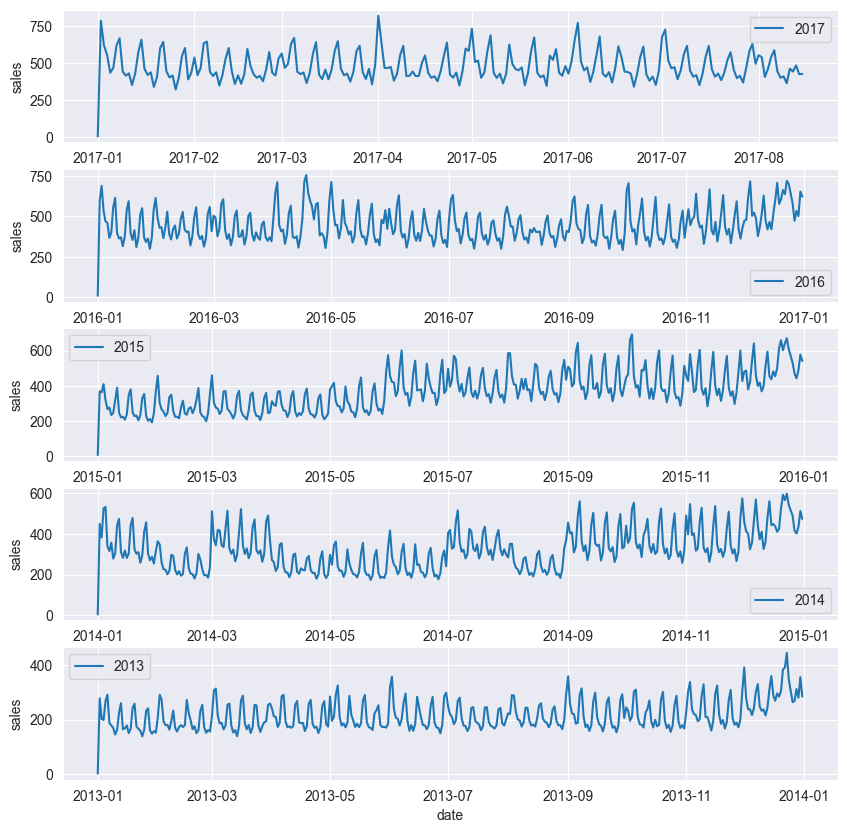

In [19]:
# plotting original data
avg = data_dict['avg'].copy()
x= avg['sales'].copy()


fig, ax = plt.subplots(5,1, figsize=(10,10))
## lets look at each year
for year in range(2013, 2018):
    year_data = data_dict['avg'][data_dict['avg'].index.year== year]
    x = year_data['sales'].copy()
    sns.lineplot(x, label=year, ax=ax[2017-year])

## We see alot of periodicity (is this a word?) in the data

Above is too dense, lets just do one year by year for now

## Initilaizing data here

[Text(0.5, 0, 'data'), Text(0, 0.5, 'day before')]

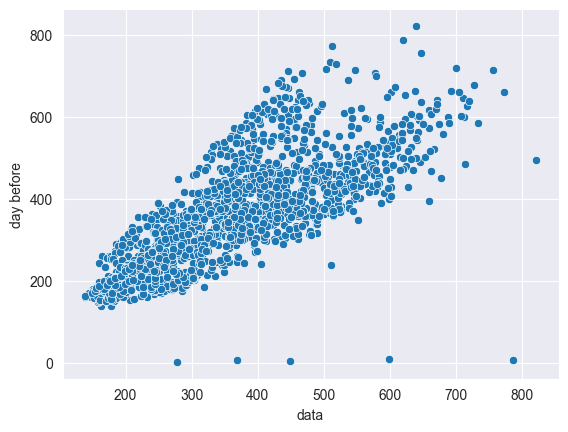

In [20]:
# what if we plot with the day respect to the day before?
data = data_dict['avg']
delayed = data.shift(1)

# drop each index for the first day of the year

data = data[data.index.dayofyear != 1]

ax = sns.scatterplot(x=data['sales'], y=delayed['sales'] )
ax.set(xlabel='data', ylabel='day before')

## disregarding the outlier seems like there is some correlation

                   id  time
date                       
2013-01-02     2672.5     0
2013-01-03     4454.5     1
2013-01-04     6236.5     2
2013-01-05     8018.5     3
2013-01-06     9800.5     4
...               ...   ...
2017-08-11  2992868.5  1674
2017-08-12  2994650.5  1675
2017-08-13  2996432.5  1676
2017-08-14  2998214.5  1677
2017-08-15  2999996.5  1678

[1679 rows x 2 columns]


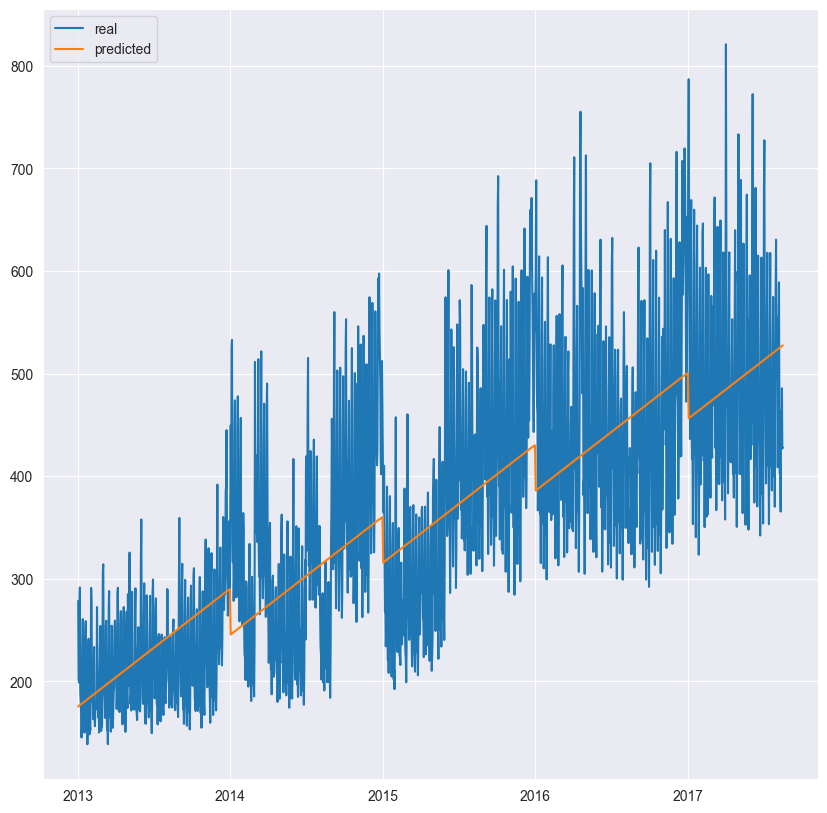

In [28]:
## fitting a linear regression
x = data.copy()

time_dummy = np.arange(len(x.index))
x['time'] = time_dummy


x = x.drop(['sales','onpromotion','id'], axis=1)
try:
    x = x.drop(['sales','onpromotion','id'], axis=1)
except:
    pass

y = data['sales'].copy()

model = LinearRegression()

model.fit(x,y)

print(x)

y_pred = pd.Series(model.predict(x), index=x.index)

## plotting the results
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(y, label='real')
ax.plot(y_pred, label='predicted')
ax.legend()

Pretty terrible response, the model only fits with the timedummy (No surprieses here)  

0.6852640945295626


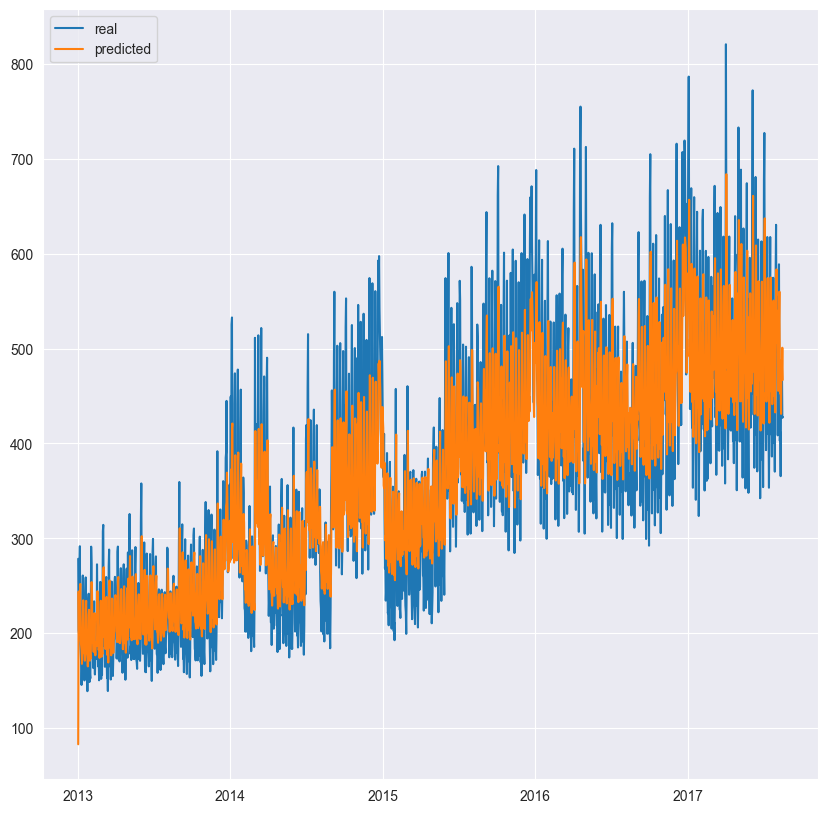

In [22]:
## what if we add the delay?
x = data.copy()
delayed = data.shift(1)
## make na to 0
delayed = delayed.fillna(0)
x['delayed'] = delayed['sales'] ## this will be the avg sales the day before

try:
    x = x.drop(['sales','onpromotion'], axis=1)
except:
    pass



y = data['sales'].copy()

model = LinearRegression()
model.fit(x,y)
y_pred = pd.Series(model.predict(x), index=x.index)


## plotting the results
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(y, label='real')
ax.plot(y_pred, label='predicted')
ax.legend()
acc = metrics.r2_score(y, y_pred)
print(acc)

Seems alot better, lets print for only 2017, to see how much better it actually performs

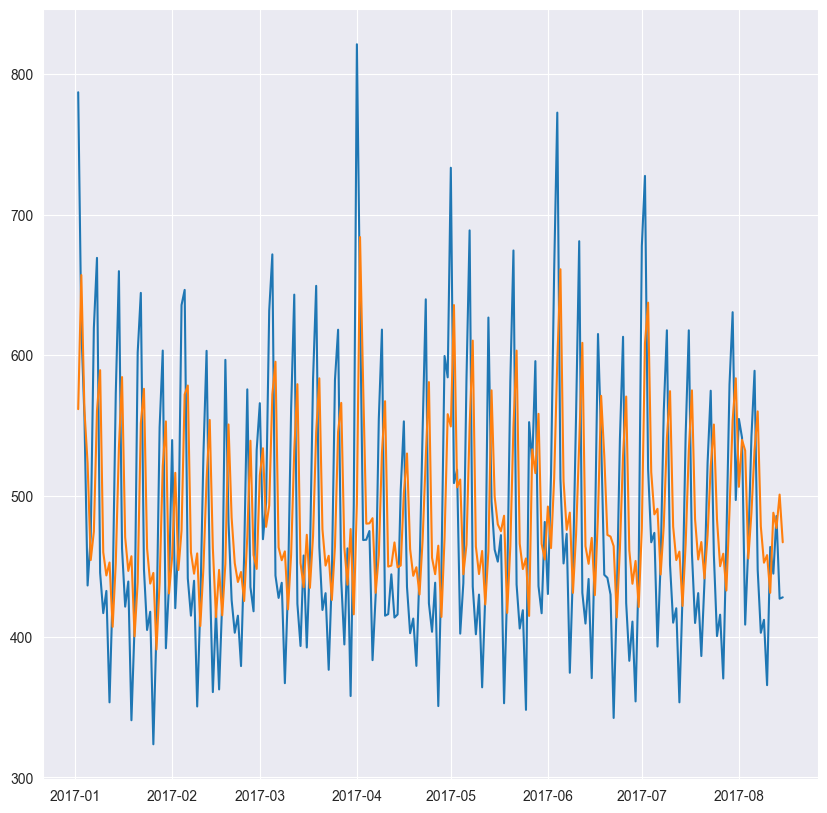

In [23]:
## plotting the data for 2017
fig, ax = plt.subplots(1,1, figsize=(10,10))
y17 = y[y.index.year==2017]
ax.plot(y17, label='real')
ax.plot(y_pred[y_pred.index.year==2017], label='predicted')

0.731832735264176


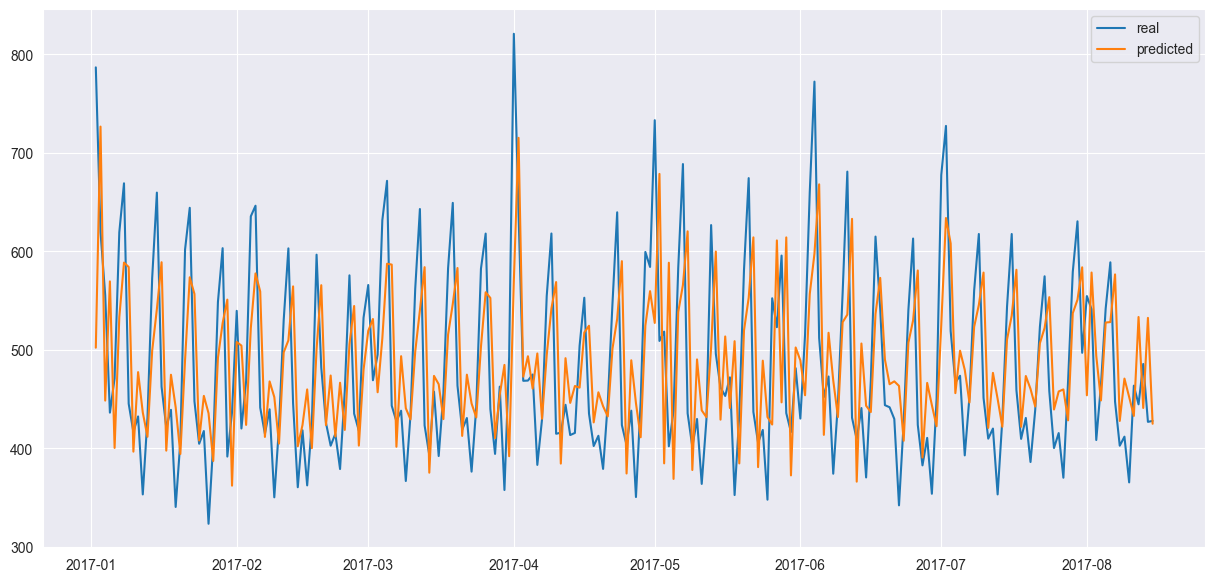

In [26]:
## lets do the same but lets also add more delay (5 days)
x = data.copy()
for i in range(1,6):
    delayed = data.shift(i)
    delayed = delayed.fillna(0)
    x['delayed'+str(i)] = delayed['sales']

try:
    x = x.drop(['sales','onpromotion'], axis=1)
except:
    pass


model = LinearRegression()
model.fit(x,y)
y_pred = pd.Series(model.predict(x), index=x.index)

## plotting the results
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(y17, label='real')
ax.plot(y_pred[y_pred.index.year==2017], label='predicted')
ax.legend()

## get the accuracy
acc = metrics.r2_score(y, y_pred)
print(acc)

Text(0.5, 1.0, 'Many delays, r2: 0.7318478262704247')

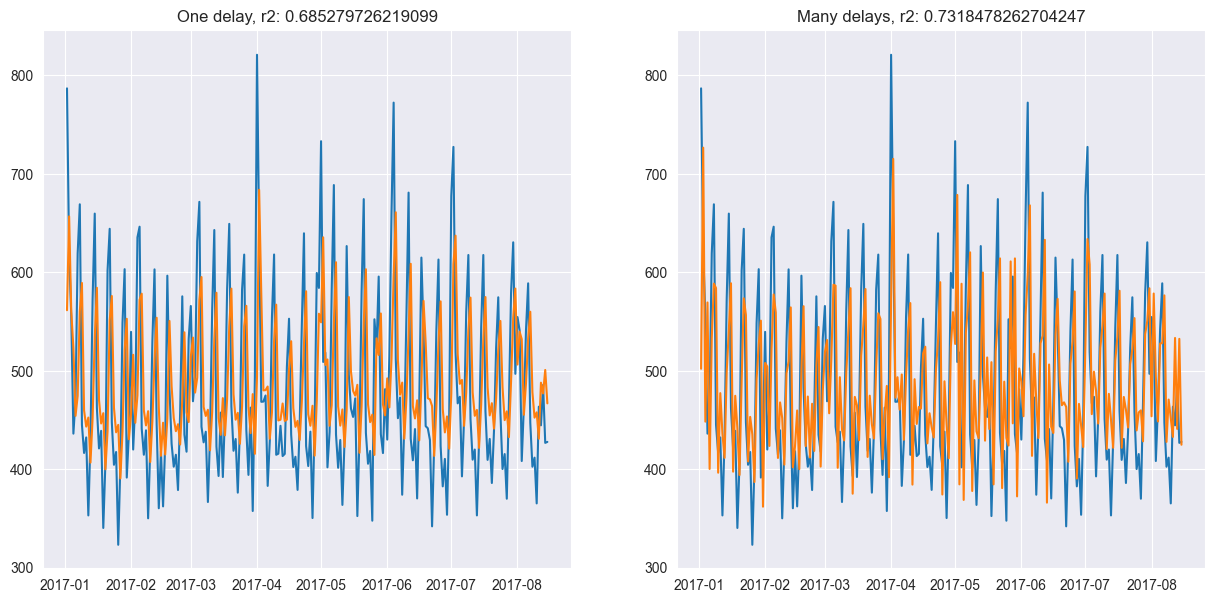

In [25]:
#Lets shorten the above code into one block and make two plots, one with many features and one with few
## lets do the same but lets also add more delay (5 days)
x = data.copy()
for i in range(1,6):
    delayed = data.shift(i)
    delayed = delayed.fillna(0)
    x['delayed'+str(i)] = delayed['sales']

try:
    x = x.drop(['sales','onpromotion','id'], axis=1)
except:
    pass

time_dummy = np.arange(len(x.index))
x['time'] = time_dummy


one_delayed = x[['delayed1','time']].copy()
many_delayed = x.copy()

model_one = LinearRegression() 
model_many = LinearRegression()

model_one.fit(one_delayed,y)
model_many.fit(many_delayed,y)

y_pred_one = pd.Series(model_one.predict(one_delayed), index=one_delayed.index)
y_pred_many = pd.Series(model_many.predict(many_delayed), index=many_delayed.index)

one_r2 = metrics.r2_score(y, y_pred_one)
many_r2 = metrics.r2_score(y, y_pred_many)

fig, ax = plt.subplots(1,2, figsize=(15,7))

ax[0].plot(y17, label='real')
ax[0].plot(y_pred_one[y_pred_one.index.year==2017], label='predicted')
ax[0].set_title('One delay, r2: '+str(one_r2))

ax[1].plot(y17, label='real')
ax[1].plot(y_pred_many[y_pred_many.index.year==2017], label='predicted')
ax[1].set_title('Many delays, r2: '+str(many_r2))
